# Text Exploration

##This notebook supports the text data exploration in the Datasets section of my thesis.

In [27]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.metrics import silhouette_score
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
from google.colab import files
import textwrap

##Annotation Dataset

In [2]:
df_annotate = pd.read_csv("ensembled_annotations_public.csv")


## SWE-Bench Verified Dataset

In [3]:
df= pd.read_csv("swe_bench_verified_test.csv")


In [5]:
df_merged = df.merge(df_annotate, on='instance_id', how='left')


In [11]:
#dropping duplicate columns and columns that provide the index number of people who made a given decision
cols_to_drop = ['difficulty_y'] + [col for col in df_merged.columns if col.endswith('_decided_by')]
df_cleaned = df_merged.drop(columns = cols_to_drop)
df_cleaned = df_cleaned.rename(columns = {'difficulty_x':'difficulty'})

---Text Length Statistics---

Character counts:
count      500.000000
mean      1699.732000
std       2048.616217
min        143.000000
25%        643.750000
50%       1185.000000
75%       2036.000000
max      24770.000000
Name: char_count, dtype: float64

Word counts:
count     500.000000
mean      189.310000
std       176.522594
min        14.000000
25%        85.000000
50%       143.000000
75%       234.250000
max      1892.000000
Name: word_count, dtype: float64


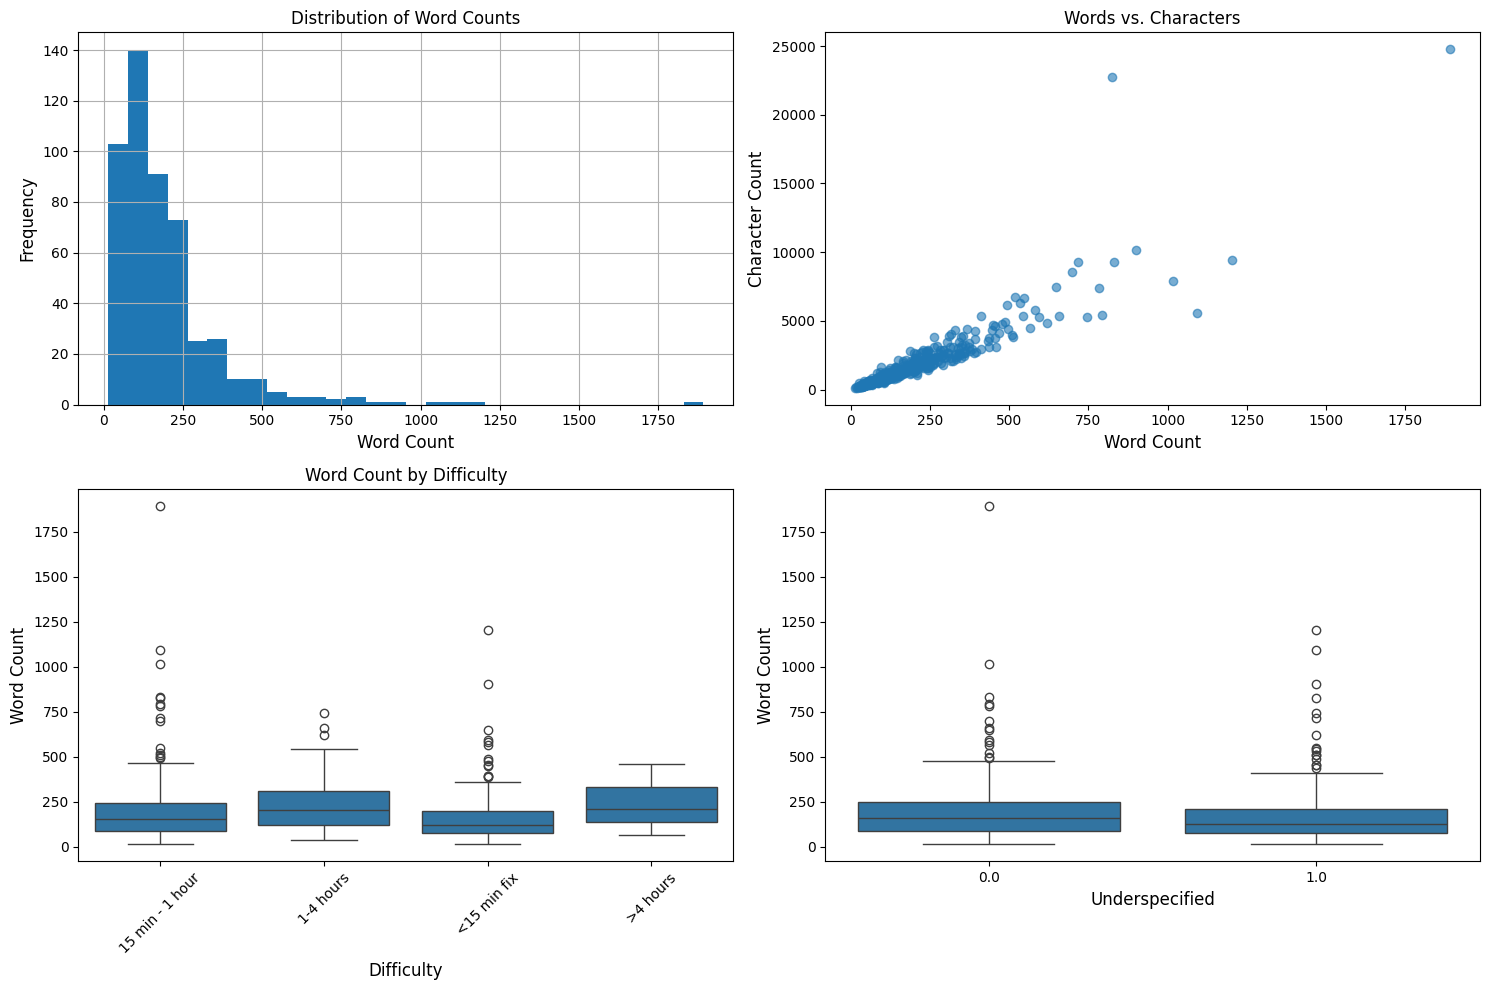


---Word count by difficulty---
                 count        mean         std   min     25%    50%     75%  \
difficulty                                                                    
1-4 hours         42.0  245.928571  177.936875  36.0  121.00  203.0  308.25   
15 min - 1 hour  261.0  199.865900  191.887350  14.0   87.00  153.0  242.00   
<15 min fix      194.0  162.000000  148.929409  18.0   78.25  121.5  197.00   
>4 hours           3.0  244.333333  199.003350  66.0  137.00  208.0  333.50   

                    max  
difficulty               
1-4 hours         745.0  
15 min - 1 hour  1892.0  
<15 min fix      1202.0  
>4 hours          459.0  

---Word count by specification quality---
                count        mean         std   min    25%    50%     75%  \
underspecified                                                              
0.0             238.0  205.281513  190.525745  19.0  91.25  160.5  248.25   
1.0             262.0  174.801527  161.766798  14.0  79.25  128

In [26]:
#calculating text metrics
problem_statements = df_cleaned['problem_statement'].fillna('')
df_cleaned['char_count'] = problem_statements.str.len()
df_cleaned['word_count'] = problem_statements.str.split().str.len()

def text_statistics_summary():
    """Function to print text stats"""
    print("---Text Length Statistics---")
    print("\nCharacter counts:")
    print(df_cleaned['char_count'].describe())
    print("\nWord counts:")
    print(df_cleaned['word_count'].describe())


def plot_text_distributions():
    """Function to create text distribution plots"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    #word count distribution
    df_cleaned['word_count'].hist(bins=30, ax=axes[0,0])
    axes[0,0].set_xlabel('Word Count', fontsize=12)
    axes[0,0].set_ylabel('Frequency', fontsize=12)
    axes[0,0].set_title('Distribution of Word Counts')

    #character vs. word count correl
    axes[0,1].scatter(df_cleaned['word_count'], df_cleaned['char_count'], alpha=0.6)
    axes[0,1].set_xlabel('Word Count', fontsize=12)
    axes[0,1].set_ylabel('Character Count', fontsize=12)
    axes[0,1].set_title('Words vs. Characters')

    #word count by difficulty
    sns.boxplot(data=df_cleaned, x='difficulty', y='word_count', ax=axes[1,0])
    axes[1,0].tick_params(axis='x', rotation=45)
    axes[1,0].set_title('Word Count by Difficulty')
    axes[1,0].set_xlabel('Difficulty', fontsize=12)
    axes[1,0].set_ylabel('Word Count', fontsize=12)

    #word count by specification quality
    sns.boxplot(data=df_cleaned, x='underspecified', y='word_count', ax=axes[1,1])
    #axes[1,1].set_title('Word Count by Specification Quality')
    axes[1,1].set_xlabel('Underspecified', fontsize=12)
    axes[1,1].set_ylabel('Word Count', fontsize=12)

    plt.tight_layout()
    plt.show()


text_statistics_summary()
plot_text_distributions()
print("\n---Word count by difficulty---")
print(df_cleaned.groupby('difficulty')['word_count'].describe())
print("\n---Word count by specification quality---")
print(df_cleaned.groupby('underspecified')['word_count'].describe())


In [28]:
def examples_by_length_and_specification():
    """Function to show examples across length/specification combinations using quartiles"""

    #defining thresholds using quartiles
    q25 = df_cleaned['word_count'].quantile(0.25)
    q75 = df_cleaned['word_count'].quantile(0.75)

    print(f"Terse: ≤{q25:.0f} words | Average: {q25:.0f}-{q75:.0f} words | Verbose: ≥{q75:.0f} words")

    #creating problem type categories
    def categorize_length(word_count):
        if word_count <= q25:
            return 'Terse'
        elif word_count >= q75:
            return 'Verbose'
        else:
            return 'Average'

    df_cleaned['length_category'] = df_cleaned['word_count'].apply(categorize_length)
    df_cleaned['spec_category'] = df_cleaned['underspecified'].apply(
        lambda x: 'Well-specified' if x == 0 else 'Underspecified'
    )

    #examples for each combination of problem type and specification level
    combinations = [
        ('Terse', 'Well-specified'),
        ('Terse', 'Underspecified'),
        ('Average', 'Well-specified'),
        ('Average', 'Underspecified'),
        ('Verbose', 'Well-specified'),
        ('Verbose', 'Underspecified')
    ]

    for length, spec in combinations:
        print(f"\n---{length} & {spec} Examples---")

        mask = (df_cleaned['length_category'] == length) & (df_cleaned['spec_category'] == spec)
        examples = df_cleaned[mask].head(2)

        print(f"Count in this category: {mask.sum()}")

        for i, (idx, row) in enumerate(examples.iterrows(), 1):
            word_count = row['word_count']
            text = row['problem_statement']
            print(f"\n{i}. ({word_count} words)")

            #wrapping the text
            wrapped_text = textwrap.fill(text[:2000], width=100)
            print(wrapped_text + "...")
            print("-" * 60)

examples_by_length_and_specification()

Terse: ≤85 words | Average: 85-234 words | Verbose: ≥234 words

---Terse & Well-specified Examples---
Count in this category: 51

1. (56 words)
Fix parse_duration() for some negative durations Description          The
​https://docs.djangoproject.com/en/2.1/_modules/django/utils/dateparse/ defines:
standard_duration_re = re.compile(         r'^'         r'(?:(?P<days>-?\d+) (days?, )?)?'
r'((?:(?P<hours>-?\d+):)(?=\d+:\d+))?'         r'(?:(?P<minutes>-?\d+):)?'
r'(?P<seconds>-?\d+)'         r'(?:\.(?P<microseconds>\d{1,6})\d{0,6})?'         r'$' ) that doesn't
match to negative durations, because of the <hours> definition final (lookahead) part does not have
'-?' in it. The following will work:         r'((?:(?P<hours>-?\d+):)(?=-?\d+:-?\d+))?' (Thanks to
Konstantin Senichev for finding the fix.)...
------------------------------------------------------------

2. (45 words)
Engine.render_to_string() should honor the autoescape attribute Description          In
Engine.render_to_string, a

In [29]:
#creates the cross-tabulation
crosstab = pd.crosstab(
    df_cleaned['length_category'],
    df_cleaned['spec_category'],
    margins=True
)
print(crosstab)

spec_category    Underspecified  Well-specified  All
length_category                                     
Average                     128             120  248
Terse                        76              51  127
Verbose                      58              67  125
All                         262             238  500
